In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import seaborn as sns
from time import perf_counter
import xgboost as xgb
from joblib import Parallel, delayed
from numpy import linalg as LA
import pandas as pd

import src.utils.preprocess as pre
from tst import Transformer
# from tst import Transformer_with_sst
import os
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.neural_network import MLPRegressor

Download only sst data (365 days per year)

In [4]:
path = '/share/data/willett-group/'


us_mask = pd.DataFrame(pd.read_hdf(path + 'us_mask.h5'))
# This block is to put all nearby sst data together in time order
# And also transform data into time order (single location\)
y_samp = pd.Series()
X_total = []

# target location
tar_lat = 33.75
tar_lon = 242.25
start = 1985 #2014

sst_all_years = np.zeros((365, 169727))

for i in range(start, 2019): #(2014,2019):
    print('precip.'+str(i)+'.h5')
#     name_precip = 'precip.'+str(i)+'.h5'
    name_sst = 'sst.'+str(i)+'.h5' 
    fileloc_sst = path + name_sst

    sst = pd.DataFrame(pd.read_hdf(fileloc_sst)).reset_index() # Daily sea surface temperature
    sst.columns = ['lat', 'lon', 'start_date', 'sst']

    
    if i%4 == 0:
        days = 366
    else:
        days = 365
    temp = sst #sst[(sst['lat']>=24.25) & (sst['lat']<=26.25) & (sst['lon']>=278.25) & (sst['lon']<=280.25)]
    print(temp.shape)
    sst_samp = temp.sst.reset_index().sst.to_numpy()
    print(sst_samp.shape)
    size = int(len(sst_samp)/days)
    sst_samp = np.reshape(sst_samp,(size, days)).transpose()[:365] # days as rows, different locations as columns
    print(sst_samp.shape)
    if i == start:
        sst_all_years = sst_samp
    else:
        sst_all_years = np.concatenate((sst_all_years, sst_samp), axis=0)
    

<ipython-input-4-68d57f8a8d8f>:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_samp = pd.Series()


precip.1985.h5
(61950355, 4)
(61950355,)
(365, 169727)
precip.1986.h5
(61950355, 4)
(61950355,)
(365, 169727)
precip.1987.h5
(61950355, 4)
(61950355,)
(365, 169727)
precip.1988.h5
(62120082, 4)
(62120082,)
(365, 169727)
precip.1989.h5
(61950355, 4)
(61950355,)
(365, 169727)
precip.1990.h5
(61950355, 4)
(61950355,)
(365, 169727)
precip.1991.h5
(61950355, 4)
(61950355,)
(365, 169727)
precip.1992.h5
(62120082, 4)
(62120082,)
(365, 169727)
precip.1993.h5
(61950355, 4)
(61950355,)
(365, 169727)
precip.1994.h5
(61950355, 4)
(61950355,)
(365, 169727)
precip.1995.h5
(61950355, 4)
(61950355,)
(365, 169727)
precip.1996.h5
(62120082, 4)
(62120082,)
(365, 169727)
precip.1997.h5
(61950355, 4)
(61950355,)
(365, 169727)
precip.1998.h5
(61950355, 4)
(61950355,)
(365, 169727)
precip.1999.h5
(61950355, 4)
(61950355,)
(365, 169727)
precip.2000.h5
(62120082, 4)
(62120082,)
(365, 169727)
precip.2001.h5
(61950355, 4)
(61950355,)
(365, 169727)
precip.2002.h5
(61950355, 4)
(61950355,)
(365, 169727)
precip.200

In [5]:
sst_samp.shape

(365, 169727)

In [6]:
sst_all_years.shape

(12410, 169727)

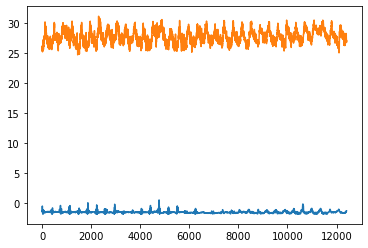

In [9]:
plt.plot(sst_all_years[:,0])
plt.plot(sst_all_years[:,100000])

In [10]:
avg_window = 14
sst_movavg = []
for i in range(sst_all_years.shape[0]-avg_window):
    y_avg = np.mean(sst_all_years[i:i+avg_window], axis=0)
    sst_movavg.append(y_avg)
sst_movavg = np.array(sst_movavg)
sst_all_years = sst_movavg

In [11]:
sst_all_years.shape

(12396, 169727)

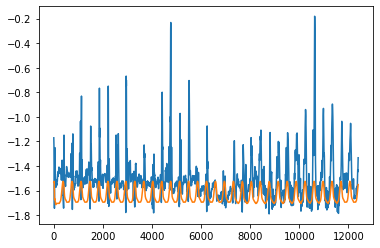

In [12]:
plt.plot(sst_all_years[:,0])
plt.plot(sst_all_years[:,100])

In [13]:
train_test_split = 0.8
test_size = int((1-train_test_split)*sst_all_years.shape[0])
X_train = sst_all_years[:-test_size]
X_test = sst_all_years[-test_size:]

In [14]:
X_train.shape, X_test.shape

((9917, 169727), (2479, 169727))

In [158]:
# from sklearn.decomposition import PCA

# n = 400

# pca = PCA(n)
# sst_data_train_pca = pca.fit_transform(X_train)
# sst_data_test_pca = pca.transform(X_test)

In [159]:
# sst_data_train_pca.shape, sst_data_test_pca.shape

((9917, 400), (2479, 400))

In [161]:
# np.save('sst_train_400pc_new_smooth.npy', sst_data_train_pca)
# np.save('sst_test_400pc_new_smooth.npy', sst_data_test_pca)

In [15]:
M = np.max(X_train)
m = np.min(X_train)
X_train = (X_train -m)/(M - m)

X_test = (X_test -m)/(M - m)

In [16]:
train_data = torch.FloatTensor(X_train)

In [17]:
train_data.shape

torch.Size([9917, 169727])

In [18]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# train_data = train_data.to(device)

In [19]:
device

device(type='cuda')

In [20]:
class SimpleDataset(Dataset):
    def __init__(self, data):
        self.samples = data

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [21]:
BATCH_SIZE = 64
dataset_train = SimpleDataset(X_train)
dataloader_train = DataLoader(dataset_train,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )

In [22]:
for x in dataloader_train:
    break

In [23]:
x.shape

torch.Size([64, 169727])

In [24]:
class AE(nn.Module):
    def __init__(self, in_shape, hid_dim):
        super(AE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(in_shape, 600),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(600, 400),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(400, hid_dim),)
        
        self.decoder = nn.Sequential(             
            nn.Linear(hid_dim, 400),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(400, 600),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(600, in_shape),
            nn.Sigmoid(),)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [25]:
hid_dim = 10

model = AE(169727, hid_dim).to(device)
distance = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #weight_decay=1e-5)

In [26]:
num_epochs = 20
losses = []
for epoch in range(num_epochs):
    running_loss = 0
    for data in dataloader_train:
        data = data.to(device)
        
        output = model(data)
        loss = distance(output, data)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss = running_loss/len(dataloader_train)
    losses.append(train_loss)
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, train_loss))

epoch [1/20], loss:0.0075
epoch [2/20], loss:0.0029
epoch [3/20], loss:0.0027
epoch [4/20], loss:0.0027
epoch [5/20], loss:0.0026
epoch [6/20], loss:0.0026
epoch [7/20], loss:0.0025
epoch [8/20], loss:0.0025
epoch [9/20], loss:0.0025
epoch [10/20], loss:0.0025
epoch [11/20], loss:0.0025
epoch [12/20], loss:0.0025
epoch [13/20], loss:0.0025
epoch [14/20], loss:0.0024
epoch [15/20], loss:0.0024
epoch [16/20], loss:0.0024
epoch [17/20], loss:0.0024
epoch [18/20], loss:0.0024
epoch [19/20], loss:0.0024
epoch [20/20], loss:0.0024


In [27]:
dataset_test = SimpleDataset(X_test)
dataloader_test = DataLoader(dataset_test,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )

In [28]:
model.eval()
running_loss = 0
with torch.no_grad():
    running_loss = 0
    for data in dataloader_test:
        data = data.to(device)
        
        output = model(data)
        
        loss = distance(output, data)
        running_loss += loss.item()
        
    test_loss = running_loss/len(dataloader_test)

In [29]:
test_loss

0.0025535044722999325

In [33]:
data.shape

torch.Size([47, 169727])

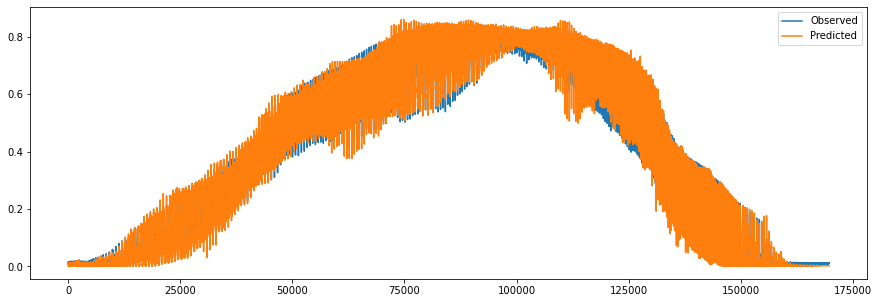

In [31]:
out = model(data[10]).cpu()

plt.figure(figsize=(15,5))
plt.plot(out.detach().numpy(),label='Observed')
plt.plot(data[10].cpu(), label='Predicted')
plt.legend();

In [32]:
model.encoder((data)).shape

torch.Size([47, 10])

In [31]:
# compressed_sst_train = model(torch.FloatTensor(X_train).to(device)).cpu()
# compressed_sst_test = model(torch.FloatTensor(X_test).to(device)).cpu()

Compress our test and train data.

In [32]:
# BATCH_SIZE = 64
# hid_dim = 10

In [34]:
compressed_sst_train = np.zeros((BATCH_SIZE, hid_dim))
compressed_sst_test = np.zeros((BATCH_SIZE, hid_dim))
model.eval()

c = 0
for data in dataloader_train:
    data = data.to(device)

    output = model.encoder((data))
    if c ==0:
        compressed_sst_train = output.data.cpu().numpy()
    else:
        compressed_sst_train = np.concatenate((compressed_sst_train, output.data.cpu().numpy()), axis=0)
    c += 1
    
c = 0    
for data in dataloader_test:
        data = data.to(device)
        
        output = model.encoder((data))
        if c ==0:
            compressed_sst_test = output.data.cpu().numpy()
        else:
            compressed_sst_test = np.concatenate((compressed_sst_test, output.data.cpu().numpy()), axis=0)
        c += 1

In [35]:
compressed_sst_train.shape, compressed_sst_test.shape

((9917, 10), (2479, 10))

In [35]:
# np.save('data/sst_tr_ae_10.npy', compressed_sst_train)
# np.save('data/sst_te_ae_10.npy', compressed_sst_test)

Download whole data (without sst) -- or skip this line and download data from .npy files on shared folder.

In [36]:
path = '/share/data/willett-group/'


us_mask = pd.DataFrame(pd.read_hdf(path + 'us_mask.h5'))
# This block is to put all nearby sst data together in time order
# And also transform data into time order (single location\)
y_samp = pd.Series()
X_total = []

# target location
tar_lat = 33.75
tar_lon = 242.25

for i in range(1985,2019): #(2014,2019):
    print('precip.'+str(i)+'.h5')
    name_precip = 'precip.'+str(i)+'.h5'
    name_sst = 'sst.'+str(i)+'.h5' 
    name_hgt = 'hgt500.'+str(i)+'.h5'
    name_rhum = 'rhum.sig995.'+str(i)+'.h5'
    name_tmp2m = 'tmp2m.'+str(i)+'.h5'
    fileloc_precip = path + name_precip
    fileloc_sst = path + name_sst
    fileloc_hgt = path + name_hgt
    fileloc_rhum = path + name_rhum
    fileloc_tmp2m = path + name_tmp2m
    precip = pd.DataFrame(pd.read_hdf(fileloc_precip)).reset_index() # precipitation
    precip.columns = ['lat', 'lon', 'start_date', 'precip']
#     sst = pd.DataFrame(pd.read_hdf(fileloc_sst)).reset_index() # Daily sea surface temperature
#     sst.columns = ['lat', 'lon', 'start_date', 'sst']
    hgt = pd.DataFrame(pd.read_hdf(fileloc_hgt)).reset_index() # Daily geopotential height at 10mb and 500mb
    hgt.columns = ['lat', 'lon', 'start_date', 'hgt']
    rhum = pd.DataFrame(pd.read_hdf(fileloc_rhum)).reset_index() # Daily relative humidity near the surface
    rhum.columns = ['lat', 'lon', 'start_date', 'rhum']
    tmp2m = pd.DataFrame(pd.read_hdf(fileloc_tmp2m)).reset_index() # Daily average temperature at 2 meters
    tmp2m.columns = ['lat', 'lon', 'start_date', 'tmp2m']
#     print('original', tmp2m.shape)
    
    precip = pd.merge(precip, us_mask, on=['lat','lon'])
    hgt = pd.merge(hgt, us_mask, on=['lat','lon'])
    rhum = pd.merge(rhum, us_mask, on=['lat','lon'])
    tmp2m = pd.merge(tmp2m, us_mask, on=['lat','lon'])
#     print('after merge', tmp2m.shape)
    
#     hgt = np.reshape(hgt[(hgt['lat']==25.25) & (hgt['lon']==279.25)].hgt.to_numpy(),(-1,1))
#     rhum = np.reshape(rhum[(rhum['lat']==25.25) & (rhum['lon']==279.25)].rhum.to_numpy(),(-1,1))
#     tmp2m = np.reshape(tmp2m[(tmp2m['lat']==25.25) & (tmp2m['lon']==279.25)].tmp2m.to_numpy(),(-1,1))
    hgt = np.reshape(hgt[(hgt['lat']==tar_lat) & (hgt['lon']==tar_lon)].hgt.to_numpy(),(-1,1))
    hgt = hgt[:365]
    rhum = np.reshape(rhum[(rhum['lat']==tar_lat) & (rhum['lon']==tar_lon)].rhum.to_numpy(),(-1,1))
    rhum = rhum[:365]
    precip = np.reshape(precip[(precip['lat']==tar_lat) & (precip['lon']==tar_lon)].precip.to_numpy(),(-1,1))
    precip = precip[:365]
    
    y_samp = y_samp.append(tmp2m[(tmp2m['lat']==tar_lat) & (tmp2m['lon']==tar_lon)].tmp2m[:365],ignore_index=True)
    
    tmp2m = np.reshape(tmp2m[(tmp2m['lat']==tar_lat) & (tmp2m['lon']==tar_lon)].tmp2m.to_numpy(),(-1,1))
    tmp2m = tmp2m[:365]
    
#     y_samp.append(tmp2m)
    #y_samp = y_samp.append(precip[(precip['lat']==tar_lat) & (precip['lon']==tar_lon)].precip,ignore_index=True)
    print('one location', tmp2m.shape)
    
#     y_samp = y_samp.append(precip[precip['lat']==25.25].precip,ignore_index=True)
    
    if i%4 == 0:
        days = 366
    else:
        days = 365
#     temp = sst #sst[(sst['lat']>=24.25) & (sst['lat']<=26.25) & (sst['lon']>=278.25) & (sst['lon']<=280.25)]
#     print(temp.shape)
#     sst_samp = temp.sst.reset_index().sst.to_numpy()
#     print(sst_samp.shape)
#     size = int(len(sst_samp)/days)
#     sst_samp = np.reshape(sst_samp,(size, days)).transpose() # days as rows, different locations as columns
#     if sst_samp.shape[0] == tmp2m.shape[0]:
#         all_features = np.concatenate((sst_samp,hgt,rhum,tmp2m),axis=1)
#     else:
#         sst_samp = sst_samp[:365]
#         hgt = hgt[:365]
#         rhum = rhum[:365]
#     sst_samp = sst_samp[:365]
    tmp2m = tmp2m[:365]
    hgt = hgt[:365]
    rhum = rhum[:365]
    all_features = np.concatenate((hgt, rhum, precip),axis=1)
    print('all_features', all_features.shape)
    X_total.append(all_features)
    
X_size = X_total[0].shape[1]
X_samp = np.zeros((1, X_size)) #  For concatenating all data
print(X_samp.shape)
for i in range(len(X_total)):
    X_samp = np.concatenate((X_samp, X_total[i]), axis = 0)
X_samp = X_samp[1:]
print(X_samp.shape)

<ipython-input-36-4768dff50e72>:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_samp = pd.Series()


precip.1985.h5
one location (365, 1)
all_features (365, 3)
precip.1986.h5
one location (365, 1)
all_features (365, 3)
precip.1987.h5
one location (365, 1)
all_features (365, 3)
precip.1988.h5
one location (365, 1)
all_features (365, 3)
precip.1989.h5
one location (365, 1)
all_features (365, 3)
precip.1990.h5
one location (365, 1)
all_features (365, 3)
precip.1991.h5
one location (365, 1)
all_features (365, 3)
precip.1992.h5
one location (365, 1)
all_features (365, 3)
precip.1993.h5
one location (365, 1)
all_features (365, 3)
precip.1994.h5
one location (365, 1)
all_features (365, 3)
precip.1995.h5
one location (365, 1)
all_features (365, 3)
precip.1996.h5
one location (365, 1)
all_features (365, 3)
precip.1997.h5
one location (365, 1)
all_features (365, 3)
precip.1998.h5
one location (365, 1)
all_features (365, 3)
precip.1999.h5
one location (365, 1)
all_features (365, 3)
precip.2000.h5
one location (365, 1)
all_features (365, 3)
precip.2001.h5
one location (365, 1)
all_features (365, 

X_samp -- (len, 3) where 3 - hgt, rhum, precip. y_samp - only tmp2 data.

In [31]:
X_samp = np.load('/share/data/willett-group/X_samp_wholetime_3features.npy')
y_samp = np.load('/share/data/willett-group/y_samp_wholetime_3features.npy')

In [37]:
X_copy = X_samp.copy()
y_copy = y_samp.copy()
target = 'tmp2m'

In [38]:
X_samp.shape, y_samp.shape

((12410, 3), (12410,))

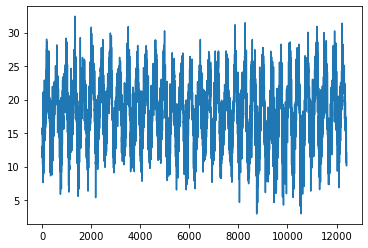

In [39]:
plt.plot(y_samp);

In [40]:
avg_window = 14
y_movavg = []
X_movavg = []
for i in range(y_samp.shape[0]-avg_window):
    y_avg = np.mean(y_samp[i:i+avg_window])
    y_movavg.append(y_avg)
    X_avg = np.mean(X_samp[i:i+avg_window],axis=0)
    X_movavg.append(X_avg)
y_movavg = np.array(y_movavg)
X_movavg = np.array(X_movavg)
y_samp = y_movavg
X_samp = X_movavg

In [41]:
X_samp.shape, y_samp.shape

((12396, 3), (12396,))

In [42]:
X = X_samp.copy()
y = y_samp.copy()

In [43]:
train_test_split = 0.8
test_size = int((1-train_test_split)*y_samp.shape[0])
X_train = X[:-test_size]
X_test = X[-test_size:]
y_train = y[:-test_size]
y_test = y[-test_size:]

In [44]:
y_train = np.reshape(y_train,(-1,1))  #  Matching dimension for concatenating X and y
y_test = np.reshape(y_test,(-1,1)) 

In [45]:
X_train.shape, X_test.shape

((9917, 3), (2479, 3))

In [46]:
M = np.max(y_train)
m = np.min(y_train)
y_train = (y_train -m)/(M - m)

X_train_max_0 = np.max(X_train[:,0])
X_train_min_0 = np.min(X_train[:,0])
X_train[:,0] = (X_train[:,0] - np.min(X_train[:,0]))/ (np.max(X_train[:,0]) - np.min(X_train[:,0]))

X_train_max_1 = np.max(X_train[:,1])
X_train_min_1 = np.min(X_train[:,1])
X_train[:,1] = (X_train[:,1] - np.min(X_train[:,1]))/(np.max(X_train[:,1]) - np.min(X_train[:,1]))

X_train_max_2 = np.max(X_train[:,2])
X_train_min_2 = np.min(X_train[:,2])
X_train[:,2] = (X_train[:,2] - np.min(X_train[:,2]))/(np.max(X_train[:,2]) - np.min(X_train[:,2]))

In [47]:
y_test = (y_test -m)/(M - m)
X_test[:,0] = (X_test[:,0] - X_train_min_0)/ (X_train_max_0 - X_train_min_0)
X_test[:,1] = (X_test[:,1] - X_train_min_1)/(X_train_max_1 - X_train_min_1)
X_test[:,2] = (X_test[:,2] - X_train_min_2)/ (X_train_max_2 - X_train_min_2)

In [48]:
print(y_train.max(), y_train.min())
print(X_train.max(), X_train.min())
print(y_test.max(), y_test.min())
print(X_test.max(), X_test.min())

1.0 0.0
1.0 0.0
0.9824147388076973 -0.005940050723798678
1.0197713628210308 -0.02969096557274323


In [49]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9917, 3), (2479, 3), (9917, 1), (2479, 1))

Concatenate data from AE and land features.

In [50]:
train_data_array = np.concatenate((compressed_sst_train, X_train, y_train), axis=1)
test_data_array = np.concatenate((compressed_sst_test, X_test, y_test), axis=1)

In [51]:
train_data_array.shape, test_data_array.shape

((9917, 14), (2479, 14))

In [52]:
train_data = torch.FloatTensor(train_data_array)
y_train = torch.FloatTensor(y_train)

In [53]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# train_data = train_data.to(device)
# y_train = y_train.to(device)

In [54]:
def create_sequence(input_data, train_window, pred_window):  #  Create sequences of observations for training
    seq = []
    L = len(input_data)
    feature_size = input_data[0].shape[0]
    print('feature_size', feature_size)
    for i in range(L - train_window-pred_window):
        train_seq = input_data[i:i+train_window]
        train_label = input_data[i+train_window+pred_window-1,feature_size-1] # get y_t+14
#         train_label = input_data[i + train_window + pred_window]
        seq.append((train_seq ,train_label))
        
    print('train_seq, train_label', train_seq.shape, train_label.shape)
    return seq

In [55]:
train_window = 90
pred_window = 28
train_seq = create_sequence(train_data, train_window, pred_window)

feature_size 14
train_seq, train_label torch.Size([90, 14]) torch.Size([])


In [56]:
from torch.utils.data import Dataset, DataLoader

class SeqDataset(Dataset):
    def __init__(self, seq_data, transform=None):
        
        self.seq_data = seq_data
        self.x = []
        self.y = []
        for i in range(len(self.seq_data)):
            self.x.append(self.seq_data[i][0])
            self.y.append(self.seq_data[i][1])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return (self.x[idx], self.y[idx])

    def __len__(self):
        return len(train_seq) #self._x.shape[0]

In [57]:
dataset_train = SeqDataset(train_seq)
dataloader_train = DataLoader(dataset_train,
                              batch_size=128,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )

In [58]:
d_input = 14 # From dataset
d_output = 1 # From dataset

attention_size = 8
LR = 1e-5 #1e-3
d_model = 64
q = 8 # Query size
v = 8 # Value size
h = 8 # Number of heads
N = 4 # Number of encoder and decoder to stack
dropout = 0.2 # Dropout rate
# pe = 'original' # Positional encoding
chunk_mode = None
net = Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, 
                  dropout=dropout, chunk_mode=chunk_mode, pe='regular', pe_period=2, seq_length=90).to(device)
# net = nn.Sequential(Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, 
#                   dropout=dropout, chunk_mode=chunk_mode, pe=pe),
#                     nn.Flatten(),
#                     nn.Linear(30, 1),
#                    ).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = nn.MSELoss() #OZELoss(alpha=0.3)

In [59]:
x.shape

torch.Size([64, 169727])

[Epoch  50/50]: 100%|██████████| 9799/9799 [00:14<00:00, 663.90it/s, loss=0.00944]


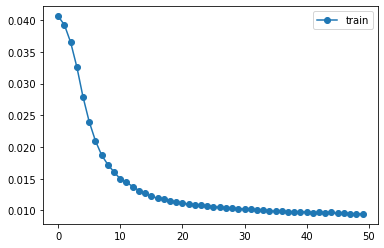

In [60]:
EPOCHS = 50
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)

for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(train_seq), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y_label) in enumerate(dataloader_train):
#             x = x.unsqueeze(0)
            y_label = y_label.view(-1,1)
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device))

            # Compute loss
#             print(netout, y)
            loss = loss_function(y_label.to(device), netout)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
                
#         scheduler.step()    
        train_loss = running_loss/len(dataloader_train)
#         print('pred, target', netout, y)
#         val_loss = compute_loss(net, dataloader_val, loss_function, device).item()
#         pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
        if idx_epoch % 10 ==0 or idx_epoch == EPOCHS-1:
            pbar.set_postfix({'loss': train_loss})

        hist_loss[idx_epoch] = train_loss
#         hist_loss_val[idx_epoch] = val_loss

#         if val_loss < val_loss_best:
#             val_loss_best = val_loss
#             torch.save(net.state_dict(), model_save_path)
        
plt.plot(hist_loss, 'o-', label='train')
# plt.plot(hist_loss_val, 'o-', label='val')
plt.legend()
# print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")

In [61]:
train_test_total = np.concatenate((train_data_array, test_data_array))

net.eval()
num_pred = 1 #  Number of prediction forward, i.e. tau
res = np.zeros(train_window).tolist()
#  Predicting y using X_test and y_test
for i in tqdm(range(train_test_total.shape[0]-train_window)):
    for j in range(num_pred):
        seq = torch.FloatTensor(train_test_total[i:i+train_window]).to(device)
        seq = seq.unsqueeze(0)
        #print(seq)
        with torch.no_grad():
            #print(model(seq))
            pred = net(seq).cpu()
            #print(len(test_inputs))
            res.append(pred)
            
res = np.array(res)

100%|██████████| 12306/12306 [03:49<00:00, 53.59it/s]


In [62]:
y_all = np.concatenate((y_train.cpu(), y_test))

r-sq on train: 0.7639786187601385
r-sq on test: 0.7392248143284397
cosine_similarity on train: [[0.98506626]]
cosine_similarity on test: [[0.98084201]]


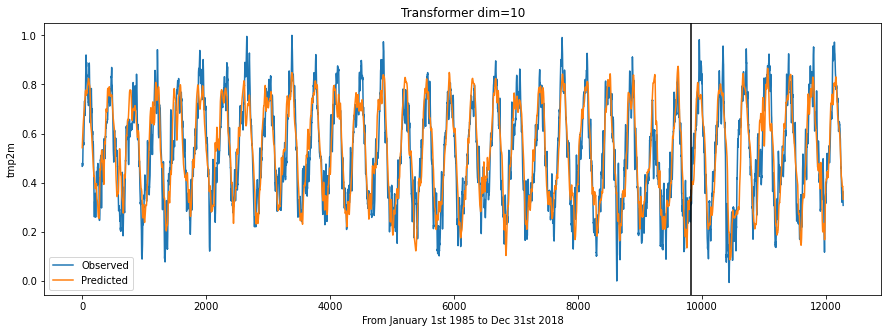

In [63]:
print('r-sq on train:', r2_score(y_all[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size-pred_window:-pred_window]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window+pred_window:-test_size].reshape((1,-1)), res[train_window:-test_size-pred_window].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  res[-test_size-pred_window:-pred_window].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer dim=10')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

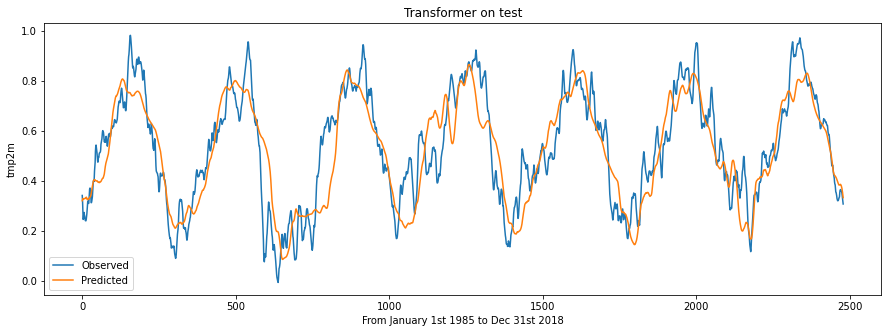

In [64]:
plt.figure(figsize=(15,5))
plt.plot(y_test,label='Observed')
plt.plot(res[-test_size-pred_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer on test');

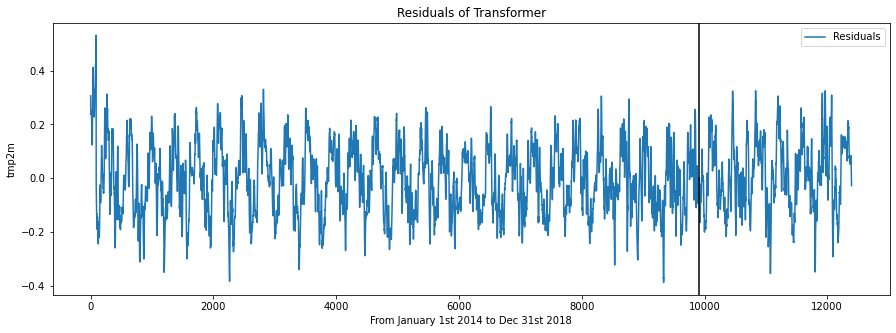

In [67]:
plt.figure(figsize=(15,5))
plt.plot(np.squeeze(y_all) - res ,label='Residuals')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Residuals of Transformer');
plt.axvline(x=X.shape[0]- test_size,c='black');

r-sq on train: 0.7639786187601385
r-sq on test: 0.7392248143284397
cosine_similarity on train: [[0.98506626]]
cosine_similarity on test: [[0.98084201]]


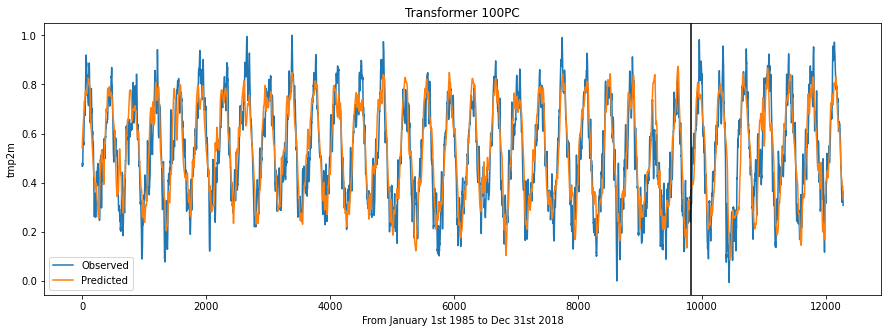

In [68]:
print('r-sq on train:', r2_score(y_all[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size-pred_window:-pred_window]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window+pred_window:-test_size].reshape((1,-1)), res[train_window:-test_size-pred_window].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  res[-test_size-pred_window:-pred_window].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer 100PC')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

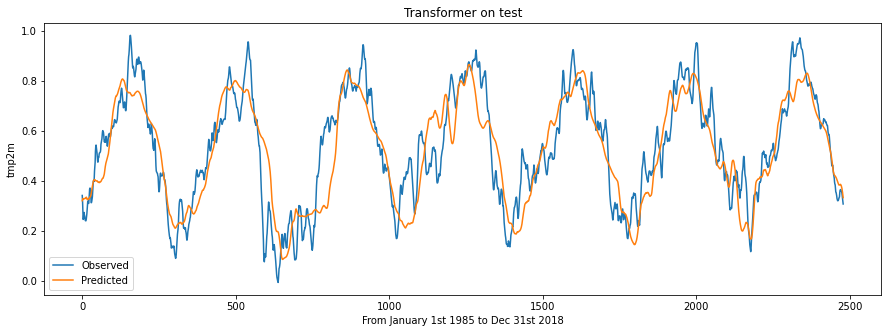

In [69]:
plt.figure(figsize=(15,5))
plt.plot(y_test,label='Observed')
plt.plot(res[-test_size-pred_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer on test');

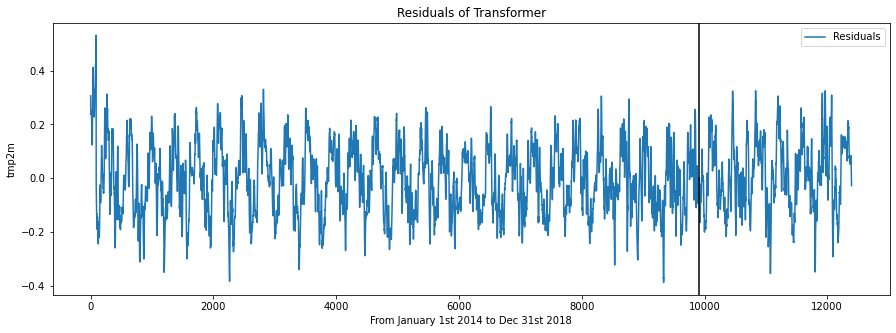

In [70]:
plt.figure(figsize=(15,5))
plt.plot(np.squeeze(y_all) - res ,label='Residuals')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Residuals of Transformer');
plt.axvline(x=X.shape[0]- test_size,c='black');

r-sq on train: 0.7639786187601385
r-sq on test: 0.7392248143284397
cosine_similarity on train: [[0.98506626]]
cosine_similarity on test: [[0.98084201]]


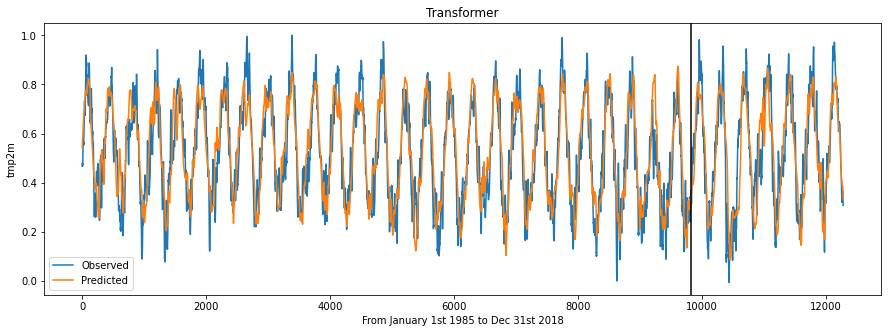

In [71]:
print('r-sq on train:', r2_score(y_all[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size-pred_window:-pred_window]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window+pred_window:-test_size].reshape((1,-1)), res[train_window:-test_size-pred_window].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  res[-test_size-pred_window:-pred_window].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

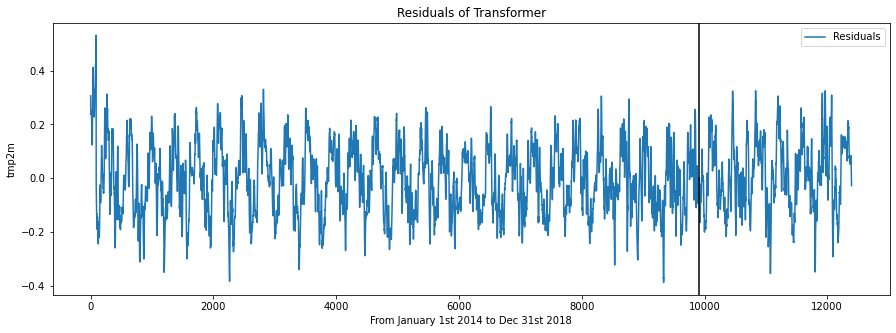

In [72]:
plt.figure(figsize=(15,5))
plt.plot(np.squeeze(y_all) - res ,label='Residuals')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Residuals of Transformer');
plt.axvline(x=X.shape[0]- test_size,c='black');

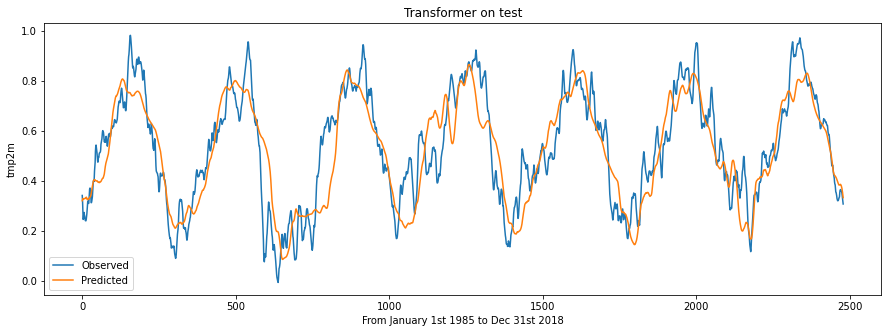

In [73]:
plt.figure(figsize=(15,5))
plt.plot(y_test,label='Observed')
plt.plot(res[-test_size-pred_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer on test');

In [3]:
class XGBoost():
    def __init__(self, num_models=3274, base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
                 min_child_weight=1, missing=None, n_estimators=100,
                 n_jobs=16, nthread=None, objective='reg:squarederror',
                 random_state=0, reg_alpha=0, reg_lambda=1,
                 scale_pos_weight=1, seed=None, silent=True, subsample=1):


        """ Initilize a list of XGBoost 
        """
        super().__init__()    

        self.models = [xgb.XGBRegressor(objective=objective, max_depth=max_depth, learning_rate=learning_rate,
                                        colsample_bytree=colsample_bytree, n_estimators=n_estimators, gamma=gamma,
                                        base_score=base_score, booster=booster, colsample_bylevel=colsample_bylevel,
                                        max_delta_step=max_delta_step, min_child_weight=min_child_weight, missing=missing,
                                        n_jobs=1, nthread=nthread, random_state=random_state,
                                        reg_alpha=reg_alpha, reg_lambda=reg_lambda,
                                        scale_pos_weight=scale_pos_weight, seed=seed,
                                        silent=silent, subsample=subsample, tree_method='gpu_hist', n_gpus=1) for i in range(num_models)]
        self.n_jobs = n_jobs
        self.num_models = num_models



    def fit(self, X, y):

        """ fit XGBoost model at each location
        """
        self.models = Parallel(n_jobs=self.n_jobs)(delayed(self.models[loc].fit)(X, y[:, loc]) for loc in range(self.num_models))# 197x2x num_estimators


        return self.models
  

    def fit_cv(self, train_x, train_y, val_x, val_y):

        """ For hyper-parameter tuning: fit XGBoost model at each location
        """
        history = np.asarray(Parallel(n_jobs=self.n_jobs)(delayed(self.fit_single_output)
                                                          (self.models[loc], train_x, train_y[:, loc], val_x, val_y[:, loc])
                                                          for loc in range(self.num_models)))# 197x2x num_estimators

        return history


    def predict(self, X):
        """ For XGBoost model at each location, make prediction
        """
        pred_y = np.asarray((Parallel(n_jobs=self.n_jobs)(delayed(self.models[loc].predict)(X) for loc in range(self.num_models))))# 197x2x num_estimators


        return pred_y.T


    def fit_single_output(self, mdl, train_x, train_y, test_x, test_y):
        """ For hyper-parameter tuning: fit XGBoost model at each location
        """
        eval_set = [(train_x, train_y), (test_x, test_y)]
        eval_metric = ['rmse']

        mdl.fit(train_x, train_y, eval_metric=eval_metric, eval_set=eval_set, verbose=True)


        train_eval = mdl.evals_result()['validation_0']['rmse']
        test_eval = mdl.evals_result()['validation_1']['rmse']


        return train_eval, test_eval

In [15]:
(X_train, y_train), (X_test, y_test) = pre.create_dataset(n_comp=20,n_sst_comp=20,target_variable='precip')

In [16]:
y_train = y_train[:,509].reshape((-1,1))
y_test = y_test[:,509].reshape((-1,1))

In [28]:
X_mins = np.amin(X_train,axis=0)
y_min = np.amin(y_train,axis=0)
X_train = X_train - X_mins
X_test = X_test - X_mins
y_train = y_train - y_min
y_test = y_test - y_min
X_maxs = np.amax(X_train,axis=0)
y_max = np.amax(y_train,axis=0)
X_train = X_train/X_maxs
X_test = X_test/X_maxs
y_train = y_train/y_max
y_test = y_test/y_max

In [37]:
mdl = XGBoost(num_models=1, n_jobs=1)
mdl.fit(X_train, y_train)
pred_train = mdl.predict(X_train)
pred_test = mdl.predict(X_test)

[03:27:01] WARNING: ../include/xgboost/generic_parameters.h:35: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.
[03:27:01] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:27:01] WARNING: ../include/xgboost/generic_parameters.h:35: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.


In [38]:
target = 'precip'

r-sq on train: 0.6807229597805512
r-sq on test: -0.07314979831218671
cosine_similarity on train: [[0.86612566]]
cosine_similarity on test: [[0.51880036]]


Text(0.5, 1.0, 'XGBoost, hid_dim=20')

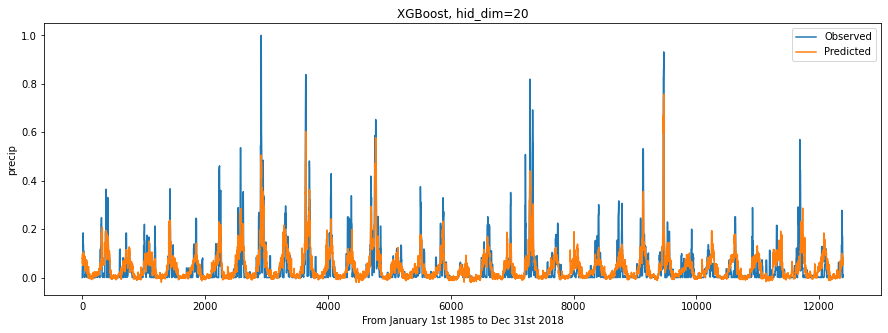

In [39]:
print('r-sq on train:', r2_score(y_train, pred_train))
print('r-sq on test:', r2_score(y_test,  pred_test))
print('cosine_similarity on train:', cosine_similarity(y_train.reshape((1,-1)), pred_train.reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_test.reshape((1,-1)),  pred_test.reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(np.concatenate((y_train, y_test)),label='Observed')
plt.plot(np.concatenate((pred_train, pred_test)),label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('XGBoost, hid_dim=20')
# plt.axvline(x=X.shape[0]- test_size,c='black');

In [40]:
mdl = MLPRegressor(hidden_layer_sizes=(1000,500,250,100,50),alpha=0.1)
mdl.fit(X_train, y_train.reshape((-1)))
pred_train = mdl.predict(X_train)
pred_test = mdl.predict(X_test)

r-sq on train: 0.26850097396421846
r-sq on test: -0.008766034927884636
cosine_similarity on train: [[0.63096977]]
cosine_similarity on test: [[0.55378662]]


Text(0.5, 1.0, 'MLP with layer sizes (1000,500,250,100,50) , hid_dim=20')

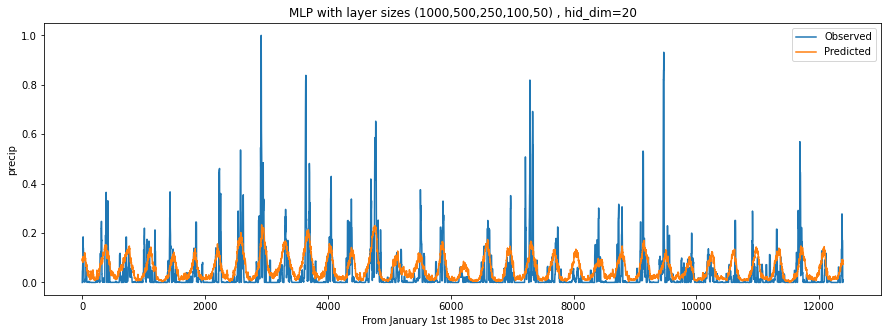

In [41]:
print('r-sq on train:', r2_score(y_train, pred_train))
print('r-sq on test:', r2_score(y_test,  pred_test))
print('cosine_similarity on train:', cosine_similarity(y_train.reshape((1,-1)), pred_train.reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_test.reshape((1,-1)),  pred_test.reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(np.concatenate((y_train, y_test)),label='Observed')
plt.plot(np.concatenate((pred_train, pred_test)),label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('MLP with layer sizes (1000,500,250,100,50) , hid_dim=20')
# plt.axvline(x=X.shape[0]- test_size,c='black');

In [42]:
train_data_array = np.concatenate((X_train, y_train), axis=1)
test_data_array = np.concatenate((X_test, y_test), axis=1)

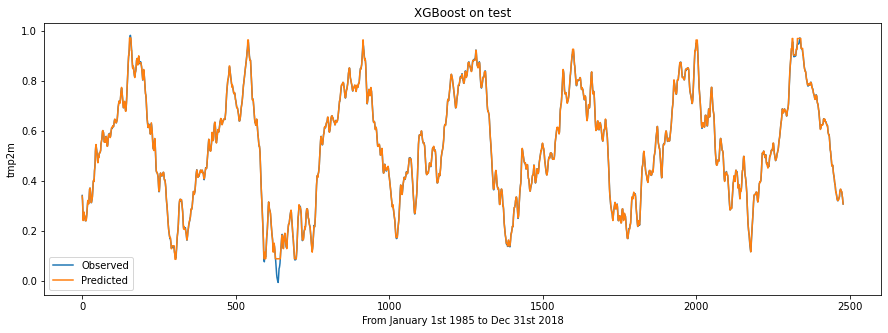

In [81]:
plt.figure(figsize=(15,5))
plt.plot(y_test,label='Observed')
plt.plot(pred_test, label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('XGBoost on test');

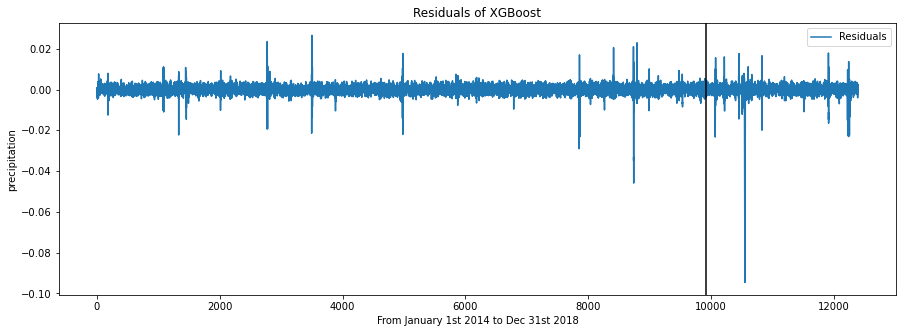

In [82]:
plt.figure(figsize=(15,5))
plt.plot(np.concatenate((y_train, y_test)) - np.concatenate((pred_train, pred_test)) ,label='Residuals')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel('precipitation')
plt.title('Residuals of XGBoost');
plt.axvline(x=X.shape[0]- test_size,c='black');

r-sq on train: 0.9998587269631103
r-sq on test: 0.9993672109527932
cosine_similarity on train: [[0.9999914]]
cosine_similarity on test: [[0.99995383]]


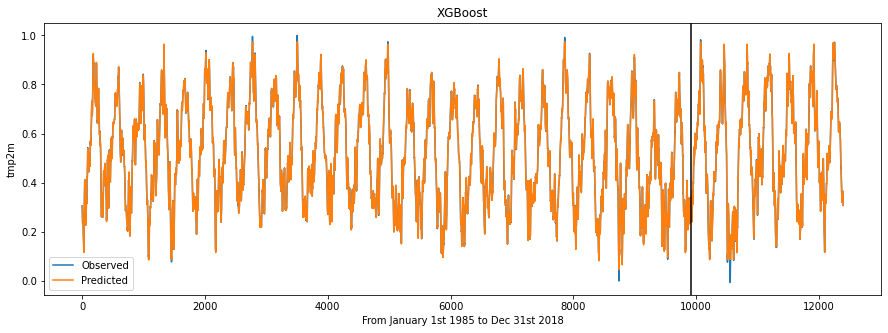

In [83]:
print('r-sq on train:', r2_score(y_train, pred_train))
print('r-sq on test:', r2_score(y_test,  pred_test))
print('cosine_similarity on train:', cosine_similarity(y_train.reshape((1,-1)), pred_train.reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_test.reshape((1,-1)),  pred_test.reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(np.concatenate((y_train, y_test)),label='Observed')
plt.plot(np.concatenate((pred_train, pred_test)),label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('XGBoost')
plt.axvline(x=X.shape[0]- test_size,c='black');

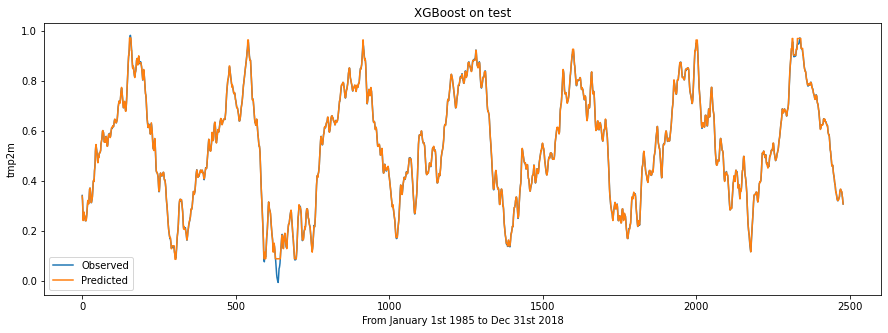

In [84]:
plt.figure(figsize=(15,5))
plt.plot(y_test,label='Observed')
plt.plot(pred_test,label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('XGBoost on test');

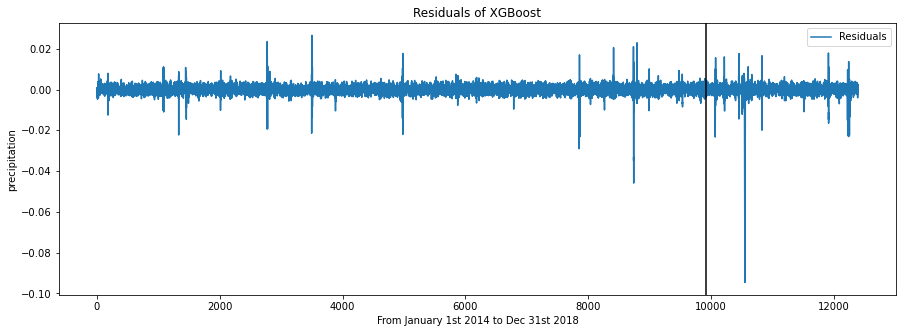

In [85]:
plt.figure(figsize=(15,5))
plt.plot(np.concatenate((y_train, y_test)) - np.concatenate((pred_train, pred_test)) ,label='Residuals')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel('precipitation')
plt.title('Residuals of XGBoost');
plt.axvline(x=X.shape[0]- test_size,c='black');

r-sq on train: 0.6787444984494566
r-sq on test: 0.7235215680175884
cosine_similarity on train: [[0.97683144]]
cosine_similarity on test: [[0.97960507]]


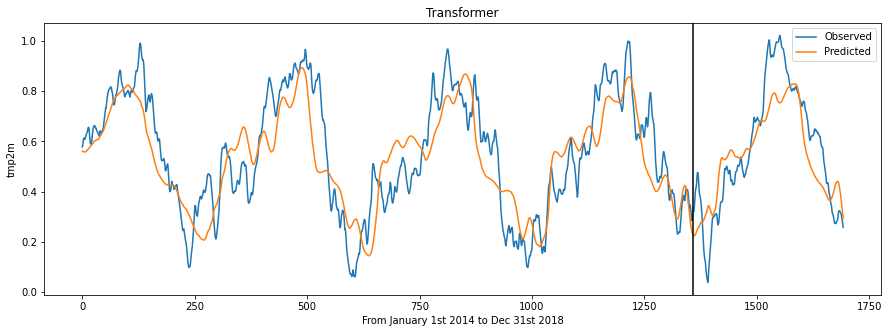

In [80]:
print('r-sq on train:', r2_score(y_all[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size-pred_window:-pred_window]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window+pred_window:-test_size].reshape((1,-1)), res[train_window:-test_size-pred_window].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  res[-test_size-pred_window:-pred_window].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

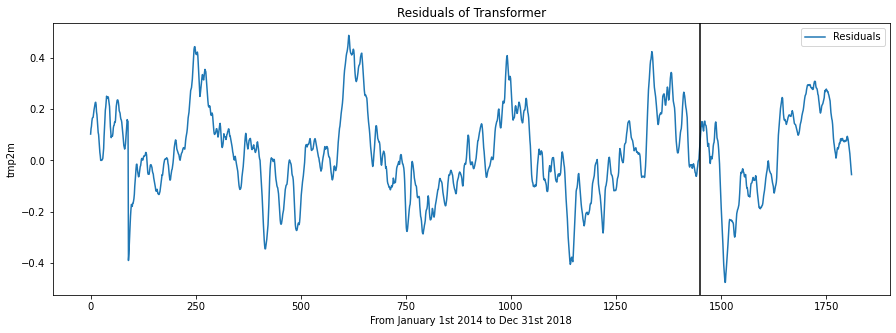

In [81]:
plt.figure(figsize=(15,5))
plt.plot(np.squeeze(y_all) - res ,label='Residuals')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Residuals of Transformer');
plt.axvline(x=X.shape[0]- test_size,c='black');

In [17]:
sst_400_train = np.load('sst_train_400pc_new_smooth.npy')
sst_400_test = np.load('sst_test_400pc_new_smooth.npy')

In [18]:
sst_400_train.shape, sst_400_test.shape

((9917, 400), (2479, 400))

In [19]:
sst_all = np.concatenate((sst_400_train, sst_400_test), axis=0)

In [20]:
sst_all.shape

(12396, 400)

In [21]:
# avg_window = 14
# # y_movavg = []
# X_movavg = []
# for i in range(y_samp.shape[0]-avg_window):
# #     y_avg = np.mean(y_samp[i:i+avg_window])
# #     y_movavg.append(y_avg)
#     X_avg = np.mean(sst_all[i:i+avg_window],axis=0)
#     X_movavg.append(X_avg)

# X_movavg = np.array(X_movavg)
# sst_samp = X_movavg

In [22]:
# sst_samp.shape

In [23]:
train_test_split_sst = 0.8
test_size_sst = int((1-train_test_split)*sst_all.shape[0])
X_train_sst = sst_all[:-test_size]
X_test_sst = sst_all[-test_size:]

In [24]:
X_train_sst.shape, X_test_sst.shape

((9917, 400), (2479, 400))

In [25]:
M = np.max(X_train_sst)
m = np.min(X_test_sst)
X_train_sst = (X_train_sst -m)/(M - m)

X_test_sst = (X_test_sst -m)/(M - m)

train_data_sst = torch.FloatTensor(X_train_sst)

In [26]:
np.max(X_train_sst), np.min(X_test_sst)

(1.0, 0.0)

In [27]:
train_data_sst.shape

torch.Size([9917, 400])

In [28]:
X_train.shape, y_train.shape

((9917, 3), (9917, 1))

In [33]:
train_window = 90
pred_window = 28
train_seq_sst = create_sequence(torch.FloatTensor(train_data_sst), train_window, pred_window)

feature_size 400
train_seq, train_label torch.Size([90, 400]) torch.Size([])


In [34]:
train_data_array = np.concatenate((X_train, y_train), axis=1)
test_data_array = np.concatenate((X_test, y_test), axis=1)
train_data = torch.FloatTensor(train_data_array)
y_train = torch.FloatTensor(y_train)

In [35]:
train_window = 90
pred_window = 28
train_seq = create_sequence(train_data, train_window, pred_window)

feature_size 4
train_seq, train_label torch.Size([90, 4]) torch.Size([])


In [36]:
from torch.utils.data import Dataset, DataLoader

class SeqDataset_sst(Dataset):
    def __init__(self, seq_data, seq_data_sst, transform=None):
        
        self.seq_data = seq_data
        self.seq_data_sst = seq_data_sst
        self.x = []
        self.y = []
        self.sst = []
        print(len(self.seq_data), len(self.seq_data_sst))
        for i in range(len(self.seq_data)):
            self.x.append(self.seq_data[i][0])
            self.y.append(self.seq_data[i][1])
            self.sst.append(self.seq_data_sst[i][0])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return (self.x[idx], self.y[idx], self.sst[idx])

    def __len__(self):
        return len(train_seq) #self._x.shape[0]

In [37]:
dataset_train = SeqDataset_sst(train_seq, train_seq_sst)
dataloader_train = DataLoader(dataset_train,
                              batch_size=128,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )

9799 9799


In [38]:
for x, t, st in dataloader_train:
    break

In [39]:
x.shape, t.shape, st.shape

(torch.Size([128, 90, 4]), torch.Size([128]), torch.Size([128, 90, 400]))

In [40]:
len(st), st[1].shape

(128, torch.Size([90, 400]))

In [43]:
d_input = 14 # From dataset
d_output = 1 # From dataset

attention_size = 8
LR = 1e-4 #1e-3
d_model = 64
q = 8 # Query size
v = 8 # Value size
h = 8 # Number of heads
N = 4 # Number of encoder and decoder to stack
dropout = 0.2 # Dropout rate
# pe = 'original' # Positional encoding
chunk_mode = None
net = Transformer_with_sst(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, 
                  dropout=dropout, chunk_mode=chunk_mode, pe='regular', pe_period=2, seq_length=90, sst_dim=400,
                  hid_dim=10).to(device)
# net = nn.Sequential(Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, 
#                   dropout=dropout, chunk_mode=chunk_mode, pe=pe),
#                     nn.Flatten(),
#                     nn.Linear(30, 1),
#                    ).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = nn.MSELoss() #OZELoss(alpha=0.3)

In [76]:
# net.dim_red.train(False);

[Epoch  50/50]: 100%|██████████| 9799/9799 [00:10<00:00, 953.02it/s, loss=0.00869] 


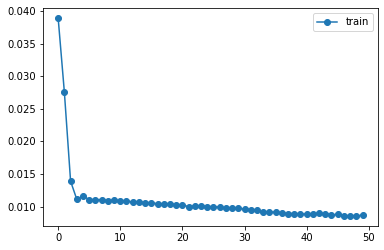

In [44]:
EPOCHS = 50
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)

for idx_epoch in range(EPOCHS):
    if idx_epoch >= 10:
#         for param in net.dim_red.parameters():
#             param.requires_grad = False
        net.dim_red.train(False)
    running_loss = 0
    with tqdm(total=len(train_seq), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y_label, sst) in enumerate(dataloader_train):
#             x = x.unsqueeze(0)
            y_label = y_label.view(-1,1)
            sst = sst.to(device)
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device), sst)

            # Compute loss
#             print(netout, y)
            loss = loss_function(y_label.to(device), netout)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
                
#         scheduler.step()    
        train_loss = running_loss/len(dataloader_train)
#         print('pred, target', netout, y)
#         val_loss = compute_loss(net, dataloader_val, loss_function, device).item()
#         pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
        if idx_epoch % 10 ==0 or idx_epoch == EPOCHS-1:
            pbar.set_postfix({'loss': train_loss})

        hist_loss[idx_epoch] = train_loss
#         hist_loss_val[idx_epoch] = val_loss

#         if val_loss < val_loss_best:
#             val_loss_best = val_loss
#             torch.save(net.state_dict(), model_save_path)
        
plt.plot(hist_loss, 'o-', label='train')
# plt.plot(hist_loss_val, 'o-', label='val')
plt.legend()
# print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")

In [45]:
train_test_total = np.concatenate((train_data_array, test_data_array)) 

net.eval()
num_pred = 1 #  Number of prediction forward, i.e. tau
res = np.zeros(train_window).tolist()
#  Predicting y using X_test and y_test
for i in tqdm(range(train_test_total.shape[0]-train_window)):
    for j in range(num_pred):
        seq = torch.FloatTensor(train_test_total[i:i+train_window]).to(device)
        seq = seq.unsqueeze(0)
        sst_seq = torch.FloatTensor(sst_all[i:i+train_window]).to(device)
        sst_seq = sst_seq.unsqueeze(0)
        #print(seq)
        with torch.no_grad():
            #print(model(seq))
            pred = net(seq, sst_seq).cpu()
            #print(len(test_inputs))
            res.append(pred)
            
res = np.array(res)

100%|██████████| 12306/12306 [04:08<00:00, 49.45it/s]


In [46]:
y_all = np.concatenate((y_train.cpu(), y_test))

r-sq on train: 0.25460790416562085
r-sq on test: 0.3250311640901451
cosine_similarity on train: [[0.95128775]]
cosine_similarity on test: [[0.95076056]]


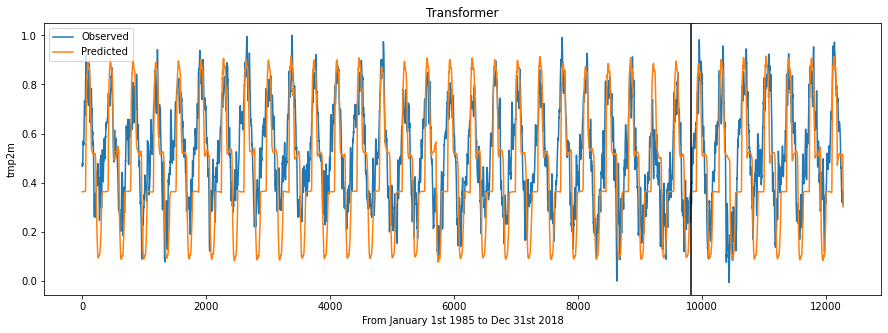

In [47]:
print('r-sq on train:', r2_score(y_all[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size-pred_window:-pred_window]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window+pred_window:-test_size].reshape((1,-1)), res[train_window:-test_size-pred_window].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  res[-test_size-pred_window:-pred_window].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

r-sq on train: 0.20968412242969703
r-sq on test: 0.17072329170395784
cosine_similarity on train: [[0.94823607]]
cosine_similarity on test: [[0.93749695]]


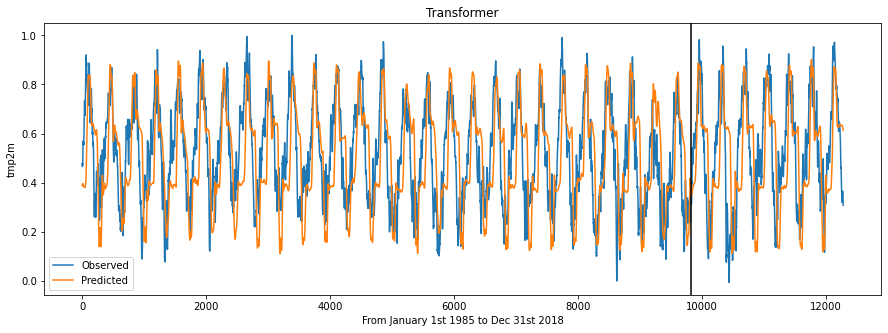

In [48]:
print('r-sq on train:', r2_score(y_all[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size-pred_window:-pred_window]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window+pred_window:-test_size].reshape((1,-1)), res[train_window:-test_size-pred_window].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  res[-test_size-pred_window:-pred_window].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

r-sq on train: -1.2483135630593871
r-sq on test: -1.0137411659815028
cosine_similarity on train: [[0.84343107]]
cosine_similarity on test: [[0.84155371]]


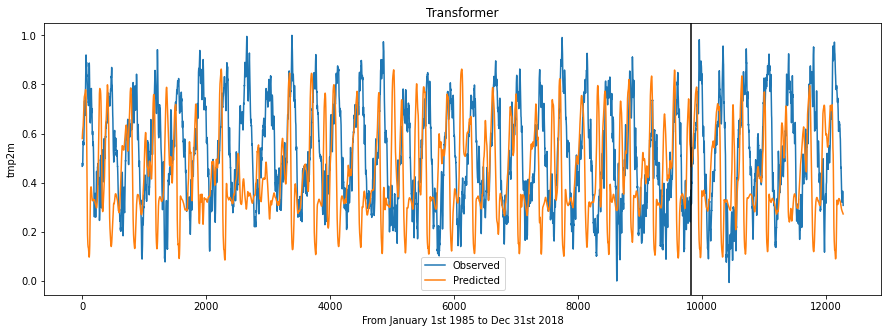

In [44]:
print('r-sq on train:', r2_score(y_all[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size-pred_window:-pred_window]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window+pred_window:-test_size].reshape((1,-1)), res[train_window:-test_size-pred_window].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  res[-test_size-pred_window:-pred_window].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

r-sq on train: -0.020851769591123448
r-sq on test: -0.04048538449191175
cosine_similarity on train: [[0.93498242]]
cosine_similarity on test: [[0.9255882]]


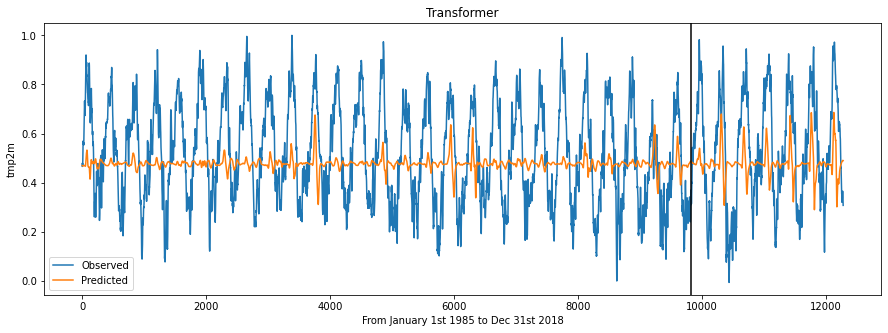

In [226]:
print('r-sq on train:', r2_score(y_all[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size-pred_window:-pred_window]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window+pred_window:-test_size].reshape((1,-1)), res[train_window:-test_size-pred_window].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  res[-test_size-pred_window:-pred_window].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');